In [ ]:
#| default_exp models.dlinear

# DLinear

DLinear is a simple and fast yet accurate time series forecasting model for long-horizon forecasting.

The architecture has the following distinctive features:
- Uses Autoformmer's trend and seasonality decomposition.
- Simple linear layers for trend and seasonality component.

**References**<br>
- [Zeng, Ailing, et al. "Are transformers effective for time series forecasting?." Proceedings of the AAAI conference on artificial intelligence. Vol. 37. No. 9. 2023."](https://ojs.aaai.org/index.php/AAAI/article/view/26317)<br>

![Figure 1. DLinear Architecture.](imgs_models/dlinear.png)

In [ ]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.common._base_windows import BaseWindows

from neuralforecast.losses.pytorch import MAE

In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Auxiliary Functions

In [ ]:
#| export
class MovingAvg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)
        
    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1].repeat(1, (self.kernel_size - 1) // 2)
        end = x[:, -1:].repeat(1, (self.kernel_size - 1) // 2)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x)
        return x
    
class SeriesDecomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.MovingAvg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.MovingAvg(x)
        res = x - moving_mean
        return res, moving_mean

## 2. DLinear

In [ ]:
#| export
class DLinear(BaseWindows):
    """ DLinear

    *Parameters:*<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, maximum sequence length for truncated train backpropagation. Default -1 uses all history.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `moving_avg_window`: int=25, window size for trend-seasonality decomposition. Should be uneven.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `scaler_type`: str='robust', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

	*References*<br>
	- Zeng, Ailing, et al. "Are transformers effective for time series forecasting?." Proceedings of the AAAI conference on artificial intelligence. Vol. 37. No. 9. 2023."
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'

    def __init__(self,
                 h: int, 
                 input_size: int,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 exclude_insample_y = False,
                 moving_avg_window: int = 25,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 **trainer_kwargs):
        super(DLinear, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       exclude_insample_y = exclude_insample_y,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       windows_batch_size=windows_batch_size,
                                       valid_batch_size=valid_batch_size,
                                       inference_windows_batch_size=inference_windows_batch_size,
                                       start_padding_enabled = start_padding_enabled,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       num_workers_loader=num_workers_loader,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       optimizer=optimizer,
                                       optimizer_kwargs=optimizer_kwargs,
                                       **trainer_kwargs)
                                                                
        # Architecture
        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        if self.stat_input_size > 0:
            raise Exception('DLinear does not support static variables yet')
        
        if self.hist_input_size > 0:
            raise Exception('DLinear does not support historical variables yet')
        
        if self.futr_input_size > 0:
            raise Exception('DLinear does not support future variables yet')

        if moving_avg_window % 2 == 0:
            raise Exception('moving_avg_window should be uneven')

        self.c_out = self.loss.outputsize_multiplier
        self.output_attention = False
        self.enc_in = 1 
        self.dec_in = 1

        # Decomposition
        self.decomp = SeriesDecomp(moving_avg_window)

        self.linear_trend = nn.Linear(self.input_size, self.loss.outputsize_multiplier * h, bias=True)
        self.linear_season = nn.Linear(self.input_size, self.loss.outputsize_multiplier * h, bias=True)

    def forward(self, windows_batch):
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']
        #futr_exog     = windows_batch['futr_exog']

        # Parse inputs
        batch_size = len(insample_y)
        seasonal_init, trend_init = self.decomp(insample_y)

        trend_part = self.linear_trend(trend_init)
        seasonal_part = self.linear_season(seasonal_init)
        
        # Final
        forecast = trend_part + seasonal_part
        forecast = forecast.reshape(batch_size, self.h, self.loss.outputsize_multiplier)
        forecast =  self.loss.domain_map(forecast)
        return forecast

In [ ]:
show_doc(DLinear)

In [ ]:
show_doc(DLinear.fit, name='DLinear.fit')

In [ ]:
show_doc(DLinear.predict, name='DLinear.predict')

## Usage Example

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

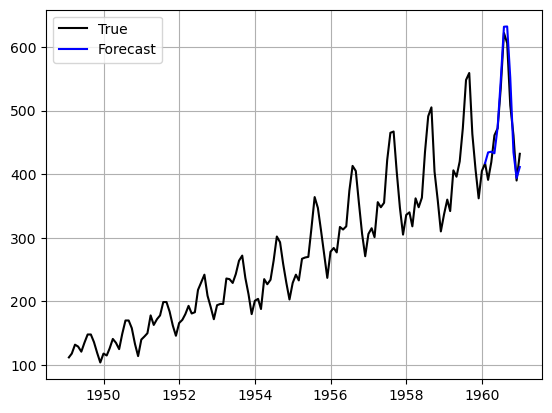

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = DLinear(h=12,
                 input_size=24,
                 loss=MAE(),
                 #loss=DistributionLoss(distribution='StudentT', level=[80, 90], return_params=True),
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['DLinear-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['DLinear-lo-90'][-12:].values, 
                    y2=plot_df['DLinear-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['DLinear'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()